In [1]:
%cd /content/drive/MyDrive/Semiconductor/data

/content/drive/MyDrive/Semiconductor/data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
IMG_PATH = './data'

In [3]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 50

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  IMG_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  IMG_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 45000 files belonging to 9 classes.
Using 36000 files for training.
Found 45000 files belonging to 9 classes.
Using 9000 files for validation.


In [4]:
class_names = train_dataset.class_names

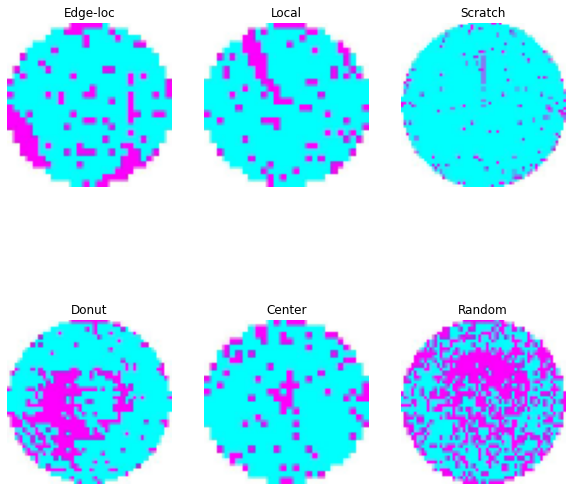

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
train_dataset = train_dataset.prefetch(buffer_size=BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BATCH_SIZE)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

In [8]:
class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

In [9]:
class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(32, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
        ]) 

        self.layer1 = self.build_cellblock(32, layers_dims[0], stride=1) 
        self.layer2 = self.build_cellblock(64, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(128, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(256, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(nb_classes, activation='softmax')
    
    def call(self, inputs, training=None):
        x = inputs
        x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
        x=self.stem(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.avgpool(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride))

        for _ in range(1, blocks):
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks

In [10]:
model = ResNet([2,2,2,2],9)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 32)        4864      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 32)        37504     
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 64)        132416    
_________________________________________________________________
sequential_3 (Sequential)    (None, 8, 8, 128)         526976    
_________________________________________________________________
sequential_4 (Sequential)    (None, 4, 4, 256)         2102528   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2313

In [11]:
epochs = 10
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
#model.fit(train_dataset, epochs=epochs)

In [ ]:
model.save_weights('./weights.h5')

In [12]:
model.load_weights('./weights.h5')

In [28]:
loss, acc = model.evaluate(validation_dataset)

180/180 [==============================] - 817s 5s/step - loss: 0.2064 - accuracy: 0.9478


Test Acc :  0.9477777481079102
Model_pred :  Center
True :  Center
Model_pred :  Scratch
True :  Scratch
Model_pred :  Local
True :  Local
Model_pred :  Near-Full
True :  Near-Full
Model_pred :  Donut
True :  Donut
Model_pred :  None
True :  None


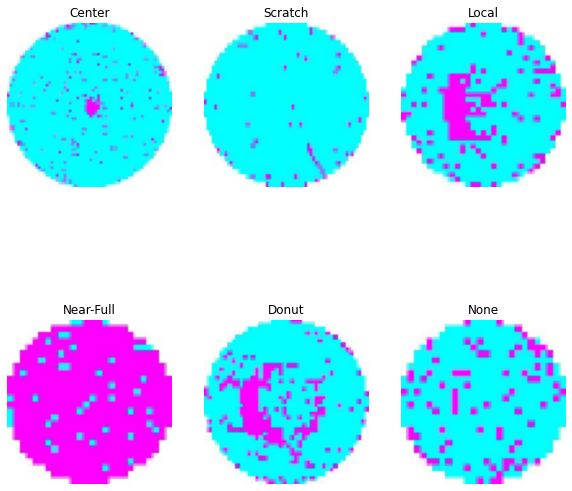

In [29]:
print("Test Acc : ", acc)
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    pred = model(images)
    pred_y = np.argmax(pred,1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[pred_y[i]])
    print("Model_pred : ",class_names[pred_y[i]])
    print("True : ", class_names[labels[i]])
    plt.axis("off")